In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/electronproton/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5
/kaggle/input/electronproton/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5


In [19]:
import os
import h5py
import gc
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.device_count() >= 2:
    print(f"Multiprocessing using {torch.cuda.device_count()} GPUs")
else:
    print("using single GPU or CPU.")

Using device: cuda
Multiprocessing using 2 GPUs


In [20]:
def load_hdf5(file_path, max_samples=None):
    with h5py.File(file_path, 'r') as f:
        total_samples = f['X'].shape[0] if max_samples is None else min(max_samples, f['X'].shape[0])
        X = f['X'][:total_samples].astype(np.float32)  # Load entire dataset into RAM
        y = f['y'][:total_samples].astype(np.int8)
    return X, y

file_path_electron = '/kaggle/input/electronproton/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5'
file_path_photon   = '/kaggle/input/electronproton/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5'

# Load the datasets
X_electron, y_electron = load_hdf5(file_path_electron)
X_photon, y_photon = load_hdf5(file_path_photon)

# Combine the two datasets
X = np.concatenate([X_electron, X_photon], axis=0)
y = np.concatenate([y_electron, y_photon], axis=0)

# Cleanup intermediate variables
del X_electron, y_electron, X_photon, y_photon
gc.collect()

print(f"Combined dataset shape: {X.shape}, Labels shape: {y.shape}")

Combined dataset shape: (498000, 32, 32, 2), Labels shape: (498000,)


In [21]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Compute normalization parameters from training data
mean = X_train.mean(axis=(0, 1, 2))
std = X_train.std(axis=(0, 1, 2))
mean = [float(m) for m in mean]
std = [float(s) for s in std]

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Normalization mean: {mean}")
print(f"Normalization std: {std}")

Train shape: (398400, 32, 32, 2), Test shape: (99600, 32, 32, 2)
Normalization mean: [0.0011494957143440843, -0.00023345656518358737]
Normalization std: [0.023609708994627, 0.06675195693969727]


In [22]:
# Define custom dataset class
class ParticleDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        image = self.X[idx]
        label = self.y[idx]
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)

# Define transforms for training and testing
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.Normalize(mean, std)
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Create dataset objects
batch_size = 256
train_dataset = ParticleDataset(X_train, y_train, transform=train_transform)
test_dataset = ParticleDataset(X_test, y_test, transform=test_transform)

# Create DataLoaders
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    num_workers=2, pin_memory=True, persistent_workers=True
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False,
    num_workers=2, pin_memory=True
)

In [23]:
# Define the basic building block
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample:
            identity = self.downsample(x)
        return F.relu(out + identity)

# Define the ResNet15 model
class ResNet15(nn.Module):
    def __init__(self):
        super().__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(2, 64, 3, 1, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(64, 2)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, 2)

    def _make_layer(self, channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, channels, 1, stride, bias=False),
                nn.BatchNorm2d(channels)
            )
        layers = [BasicBlock(self.in_channels, channels, stride, downsample)]
        self.in_channels = channels
        for _ in range(1, blocks):
            layers.append(BasicBlock(channels, channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

# Instantiate and wrap the model for multi-GPU if available
model = ResNet15()
if torch.cuda.device_count() >= 2:
    model = nn.DataParallel(model, device_ids=[0, 1])
model = model.to(device)
print(model)

DataParallel(
  (module): ResNet15(
    (conv1): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-

In [24]:
# Loss, optimizer, scheduler and scaler setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
scaler = torch.amp.GradScaler("cuda")

# Initialize history for metrics tracking
history = {'train_loss': [], 'train_auc': [], 'test_acc': [], 'test_auc': []}
best_auc = 0.0

In [25]:
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    all_train_probs = []
    all_train_labels = []

    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        
        with torch.amp.autocast("cuda", dtype=torch.float16):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
        probs = F.softmax(outputs, dim=1)[:, 1].detach().cpu().numpy()
        all_train_probs.extend(probs)
        all_train_labels.extend(labels.cpu().numpy().astype(int))

    # Validation phase
    model.eval()
    test_probs = []
    test_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            test_probs.extend(probs)
            test_labels.extend(labels.cpu().numpy().astype(int))

    train_loss_avg = train_loss / len(train_loader)
    train_auc = roc_auc_score(all_train_labels, all_train_probs)
    test_auc = roc_auc_score(test_labels, test_probs)
    test_acc = (np.array(test_probs) > 0.5).mean()

    # Update history
    history['train_loss'].append(train_loss_avg)
    history['train_auc'].append(train_auc)
    history['test_auc'].append(test_auc)
    history['test_acc'].append(test_acc)

    scheduler.step()

    # Save best model
    if test_auc > best_auc:
        best_auc = test_auc
        torch.save(model.state_dict(), '/kaggle/working/best_model_kaggle.pth')

    print(f"\nEpoch {epoch+1:02d}")
    print(f"Train Loss: {train_loss_avg:.4f} | Train AUC: {train_auc:.4f}")
    print(f"Test Acc: {test_acc:.4f} | Test AUC: {test_auc:.4f}")
    print(f"Peak GPU Memory: {torch.cuda.max_memory_allocated()/1e9:.2f} GB")
    torch.cuda.reset_peak_memory_stats()

Epoch 1/50: 100%|██████████| 1557/1557 [01:35<00:00, 16.32it/s]



Epoch 01
Train Loss: 0.6120 | Train AUC: 0.7213
Test Acc: 0.4123 | Test AUC: 0.7613
Peak GPU Memory: 0.36 GB


Epoch 2/50: 100%|██████████| 1557/1557 [01:34<00:00, 16.44it/s]



Epoch 02
Train Loss: 0.5727 | Train AUC: 0.7707
Test Acc: 0.6173 | Test AUC: 0.7809
Peak GPU Memory: 0.36 GB


Epoch 3/50: 100%|██████████| 1557/1557 [01:34<00:00, 16.42it/s]



Epoch 03
Train Loss: 0.5642 | Train AUC: 0.7797
Test Acc: 0.5684 | Test AUC: 0.7853
Peak GPU Memory: 0.36 GB


Epoch 4/50: 100%|██████████| 1557/1557 [01:34<00:00, 16.49it/s]



Epoch 04
Train Loss: 0.5595 | Train AUC: 0.7842
Test Acc: 0.4887 | Test AUC: 0.7887
Peak GPU Memory: 0.36 GB


Epoch 5/50: 100%|██████████| 1557/1557 [01:34<00:00, 16.53it/s]



Epoch 05
Train Loss: 0.5571 | Train AUC: 0.7866
Test Acc: 0.5968 | Test AUC: 0.7714
Peak GPU Memory: 0.36 GB


Epoch 6/50: 100%|██████████| 1557/1557 [01:34<00:00, 16.54it/s]



Epoch 06
Train Loss: 0.5540 | Train AUC: 0.7897
Test Acc: 0.5430 | Test AUC: 0.7988
Peak GPU Memory: 0.36 GB


Epoch 7/50: 100%|██████████| 1557/1557 [01:34<00:00, 16.40it/s]



Epoch 07
Train Loss: 0.5520 | Train AUC: 0.7916
Test Acc: 0.5741 | Test AUC: 0.7910
Peak GPU Memory: 0.36 GB


Epoch 8/50: 100%|██████████| 1557/1557 [01:33<00:00, 16.59it/s]



Epoch 08
Train Loss: 0.5498 | Train AUC: 0.7937
Test Acc: 0.4884 | Test AUC: 0.7966
Peak GPU Memory: 0.36 GB


Epoch 9/50: 100%|██████████| 1557/1557 [01:33<00:00, 16.56it/s]



Epoch 09
Train Loss: 0.5481 | Train AUC: 0.7952
Test Acc: 0.5321 | Test AUC: 0.8003
Peak GPU Memory: 0.36 GB


Epoch 10/50: 100%|██████████| 1557/1557 [01:34<00:00, 16.52it/s]



Epoch 10
Train Loss: 0.5465 | Train AUC: 0.7966
Test Acc: 0.5255 | Test AUC: 0.8017
Peak GPU Memory: 0.36 GB


Epoch 11/50: 100%|██████████| 1557/1557 [01:34<00:00, 16.44it/s]



Epoch 11
Train Loss: 0.5450 | Train AUC: 0.7982
Test Acc: 0.5252 | Test AUC: 0.7927
Peak GPU Memory: 0.36 GB


Epoch 12/50: 100%|██████████| 1557/1557 [01:35<00:00, 16.35it/s]



Epoch 12
Train Loss: 0.5444 | Train AUC: 0.7987
Test Acc: 0.5701 | Test AUC: 0.8031
Peak GPU Memory: 0.36 GB


Epoch 13/50: 100%|██████████| 1557/1557 [01:34<00:00, 16.47it/s]



Epoch 13
Train Loss: 0.5425 | Train AUC: 0.8004
Test Acc: 0.5165 | Test AUC: 0.8032
Peak GPU Memory: 0.36 GB


Epoch 14/50: 100%|██████████| 1557/1557 [01:35<00:00, 16.36it/s]



Epoch 14
Train Loss: 0.5415 | Train AUC: 0.8013
Test Acc: 0.5306 | Test AUC: 0.7997
Peak GPU Memory: 0.36 GB


Epoch 15/50: 100%|██████████| 1557/1557 [01:35<00:00, 16.39it/s]



Epoch 15
Train Loss: 0.5403 | Train AUC: 0.8023
Test Acc: 0.5377 | Test AUC: 0.8030
Peak GPU Memory: 0.36 GB


Epoch 16/50: 100%|██████████| 1557/1557 [01:34<00:00, 16.55it/s]



Epoch 16
Train Loss: 0.5395 | Train AUC: 0.8032
Test Acc: 0.5492 | Test AUC: 0.8021
Peak GPU Memory: 0.36 GB


Epoch 17/50: 100%|██████████| 1557/1557 [01:36<00:00, 16.17it/s]



Epoch 17
Train Loss: 0.5385 | Train AUC: 0.8040
Test Acc: 0.5187 | Test AUC: 0.8055
Peak GPU Memory: 0.36 GB


Epoch 18/50: 100%|██████████| 1557/1557 [01:34<00:00, 16.41it/s]



Epoch 18
Train Loss: 0.5374 | Train AUC: 0.8050
Test Acc: 0.4776 | Test AUC: 0.8027
Peak GPU Memory: 0.36 GB


Epoch 19/50: 100%|██████████| 1557/1557 [01:34<00:00, 16.42it/s]



Epoch 19
Train Loss: 0.5363 | Train AUC: 0.8060
Test Acc: 0.5031 | Test AUC: 0.8060
Peak GPU Memory: 0.36 GB


Epoch 20/50: 100%|██████████| 1557/1557 [01:34<00:00, 16.41it/s]



Epoch 20
Train Loss: 0.5356 | Train AUC: 0.8065
Test Acc: 0.4613 | Test AUC: 0.8015
Peak GPU Memory: 0.36 GB


Epoch 21/50: 100%|██████████| 1557/1557 [01:34<00:00, 16.44it/s]



Epoch 21
Train Loss: 0.5344 | Train AUC: 0.8075
Test Acc: 0.5103 | Test AUC: 0.8068
Peak GPU Memory: 0.36 GB


Epoch 22/50: 100%|██████████| 1557/1557 [01:34<00:00, 16.43it/s]



Epoch 22
Train Loss: 0.5334 | Train AUC: 0.8085
Test Acc: 0.5471 | Test AUC: 0.8037
Peak GPU Memory: 0.36 GB


Epoch 23/50: 100%|██████████| 1557/1557 [01:34<00:00, 16.42it/s]



Epoch 23
Train Loss: 0.5322 | Train AUC: 0.8095
Test Acc: 0.4769 | Test AUC: 0.8064
Peak GPU Memory: 0.36 GB


Epoch 24/50: 100%|██████████| 1557/1557 [01:37<00:00, 15.97it/s]



Epoch 24
Train Loss: 0.5316 | Train AUC: 0.8100
Test Acc: 0.5269 | Test AUC: 0.8073
Peak GPU Memory: 0.36 GB


Epoch 25/50: 100%|██████████| 1557/1557 [01:35<00:00, 16.30it/s]



Epoch 25
Train Loss: 0.5304 | Train AUC: 0.8110
Test Acc: 0.5298 | Test AUC: 0.8094
Peak GPU Memory: 0.36 GB


Epoch 26/50: 100%|██████████| 1557/1557 [01:34<00:00, 16.46it/s]



Epoch 26
Train Loss: 0.5295 | Train AUC: 0.8119
Test Acc: 0.5391 | Test AUC: 0.8097
Peak GPU Memory: 0.36 GB


Epoch 27/50: 100%|██████████| 1557/1557 [01:35<00:00, 16.28it/s]



Epoch 27
Train Loss: 0.5285 | Train AUC: 0.8126
Test Acc: 0.4947 | Test AUC: 0.8069
Peak GPU Memory: 0.36 GB


Epoch 28/50: 100%|██████████| 1557/1557 [01:35<00:00, 16.28it/s]



Epoch 28
Train Loss: 0.5274 | Train AUC: 0.8136
Test Acc: 0.5362 | Test AUC: 0.8106
Peak GPU Memory: 0.36 GB


Epoch 29/50: 100%|██████████| 1557/1557 [01:35<00:00, 16.29it/s]



Epoch 29
Train Loss: 0.5266 | Train AUC: 0.8143
Test Acc: 0.5128 | Test AUC: 0.8121
Peak GPU Memory: 0.36 GB


Epoch 30/50: 100%|██████████| 1557/1557 [01:35<00:00, 16.28it/s]



Epoch 30
Train Loss: 0.5257 | Train AUC: 0.8150
Test Acc: 0.5157 | Test AUC: 0.8112
Peak GPU Memory: 0.36 GB


Epoch 31/50: 100%|██████████| 1557/1557 [01:34<00:00, 16.39it/s]



Epoch 31
Train Loss: 0.5245 | Train AUC: 0.8159
Test Acc: 0.5006 | Test AUC: 0.8119
Peak GPU Memory: 0.36 GB


Epoch 32/50: 100%|██████████| 1557/1557 [01:35<00:00, 16.39it/s]



Epoch 32
Train Loss: 0.5237 | Train AUC: 0.8166
Test Acc: 0.5092 | Test AUC: 0.8113
Peak GPU Memory: 0.36 GB


Epoch 33/50: 100%|██████████| 1557/1557 [01:33<00:00, 16.66it/s]



Epoch 33
Train Loss: 0.5229 | Train AUC: 0.8174
Test Acc: 0.5203 | Test AUC: 0.8128
Peak GPU Memory: 0.36 GB


Epoch 34/50: 100%|██████████| 1557/1557 [01:33<00:00, 16.71it/s]



Epoch 34
Train Loss: 0.5219 | Train AUC: 0.8182
Test Acc: 0.5059 | Test AUC: 0.8129
Peak GPU Memory: 0.36 GB


Epoch 35/50: 100%|██████████| 1557/1557 [01:33<00:00, 16.72it/s]



Epoch 35
Train Loss: 0.5208 | Train AUC: 0.8191
Test Acc: 0.5006 | Test AUC: 0.8131
Peak GPU Memory: 0.36 GB


Epoch 36/50: 100%|██████████| 1557/1557 [01:33<00:00, 16.67it/s]



Epoch 36
Train Loss: 0.5199 | Train AUC: 0.8198
Test Acc: 0.5129 | Test AUC: 0.8135
Peak GPU Memory: 0.36 GB


Epoch 37/50: 100%|██████████| 1557/1557 [01:33<00:00, 16.69it/s]



Epoch 37
Train Loss: 0.5191 | Train AUC: 0.8205
Test Acc: 0.5076 | Test AUC: 0.8135
Peak GPU Memory: 0.36 GB


Epoch 38/50: 100%|██████████| 1557/1557 [01:32<00:00, 16.77it/s]



Epoch 38
Train Loss: 0.5181 | Train AUC: 0.8214
Test Acc: 0.5189 | Test AUC: 0.8127
Peak GPU Memory: 0.36 GB


Epoch 39/50: 100%|██████████| 1557/1557 [01:32<00:00, 16.75it/s]



Epoch 39
Train Loss: 0.5179 | Train AUC: 0.8215
Test Acc: 0.5228 | Test AUC: 0.8140
Peak GPU Memory: 0.36 GB


Epoch 40/50: 100%|██████████| 1557/1557 [01:33<00:00, 16.58it/s]



Epoch 40
Train Loss: 0.5169 | Train AUC: 0.8223
Test Acc: 0.5106 | Test AUC: 0.8139
Peak GPU Memory: 0.36 GB


Epoch 41/50: 100%|██████████| 1557/1557 [01:35<00:00, 16.36it/s]



Epoch 41
Train Loss: 0.5161 | Train AUC: 0.8229
Test Acc: 0.5118 | Test AUC: 0.8139
Peak GPU Memory: 0.36 GB


Epoch 42/50: 100%|██████████| 1557/1557 [01:35<00:00, 16.30it/s]



Epoch 42
Train Loss: 0.5153 | Train AUC: 0.8237
Test Acc: 0.5252 | Test AUC: 0.8136
Peak GPU Memory: 0.36 GB


Epoch 43/50: 100%|██████████| 1557/1557 [01:35<00:00, 16.36it/s]



Epoch 43
Train Loss: 0.5149 | Train AUC: 0.8239
Test Acc: 0.5042 | Test AUC: 0.8140
Peak GPU Memory: 0.36 GB


Epoch 44/50: 100%|██████████| 1557/1557 [01:35<00:00, 16.25it/s]



Epoch 44
Train Loss: 0.5145 | Train AUC: 0.8241
Test Acc: 0.5091 | Test AUC: 0.8143
Peak GPU Memory: 0.36 GB


Epoch 45/50: 100%|██████████| 1557/1557 [01:35<00:00, 16.25it/s]



Epoch 45
Train Loss: 0.5141 | Train AUC: 0.8245
Test Acc: 0.4986 | Test AUC: 0.8141
Peak GPU Memory: 0.36 GB


Epoch 46/50: 100%|██████████| 1557/1557 [01:35<00:00, 16.26it/s]



Epoch 46
Train Loss: 0.5138 | Train AUC: 0.8247
Test Acc: 0.5149 | Test AUC: 0.8143
Peak GPU Memory: 0.36 GB


Epoch 47/50: 100%|██████████| 1557/1557 [01:36<00:00, 16.14it/s]



Epoch 47
Train Loss: 0.5135 | Train AUC: 0.8250
Test Acc: 0.5001 | Test AUC: 0.8142
Peak GPU Memory: 0.36 GB


Epoch 48/50: 100%|██████████| 1557/1557 [01:35<00:00, 16.22it/s]



Epoch 48
Train Loss: 0.5134 | Train AUC: 0.8251
Test Acc: 0.5091 | Test AUC: 0.8142
Peak GPU Memory: 0.36 GB


Epoch 49/50: 100%|██████████| 1557/1557 [01:35<00:00, 16.36it/s]



Epoch 49
Train Loss: 0.5131 | Train AUC: 0.8254
Test Acc: 0.5106 | Test AUC: 0.8143
Peak GPU Memory: 0.36 GB


Epoch 50/50: 100%|██████████| 1557/1557 [01:34<00:00, 16.42it/s]



Epoch 50
Train Loss: 0.5132 | Train AUC: 0.8251
Test Acc: 0.5065 | Test AUC: 0.8143
Peak GPU Memory: 0.36 GB


In [27]:
# Load the best saved model and evaluate on the test set
state_dict = torch.load('/kaggle/working/best_model_kaggle.pth', weights_only=True)
model.load_state_dict(state_dict)

model.eval()

all_probs = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probs = F.softmax(outputs, dim=1)[:, 1].cpu().numpy()
        all_probs.extend(probs)
        all_labels.extend(labels.numpy().astype(int))

final_auc = roc_auc_score(all_labels, all_probs)
final_acc = (np.array(all_probs) > 0.5).mean()

print("\n★ Final Results ★")
print(f"Test Accuracy: {final_acc:.4f}")
print(f"Test AUC: {final_auc:.4f}")


★ Final Results ★
Test Accuracy: 0.5149
Test AUC: 0.8143


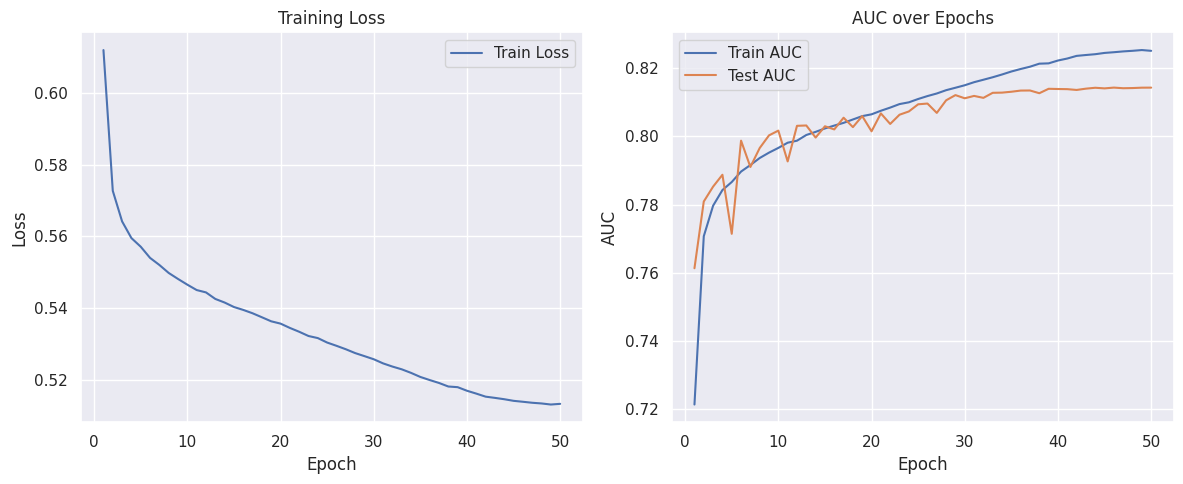

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid")

# Plot Training Loss and AUC
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history['train_loss'], label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history['train_auc'], label='Train AUC')
plt.plot(epochs, history['test_auc'], label='Test AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('AUC over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [29]:
# end of common task